# Photutils tutorial


## Morphological properties
Source: https://photutils.readthedocs.io/en/stable/morphology.html

## Elliptical Isophote Analysis
Source: https://photutils.readthedocs.io/en/stable/isophote.html

In [1]:
# import relevant packages
import numpy as np
import matplotlib.pyplot as plt
from astropy.modeling.models import Gaussian2D
from astropy.stats import sigma_clipped_stats
from photutils.datasets import make_noise_image
from photutils.isophote import EllipseGeometry, Ellipse, build_ellipse_model
from photutils import EllipticalAperture, data_properties
from astropy.io import fits

In [2]:
#data = g(x, y) + noise
hdu=fits.open('/Users/lasilla/data/2020-02-10/reduced/NGC3311/NGC3311_V.fits')
data = hdu['PRIMARY'].data

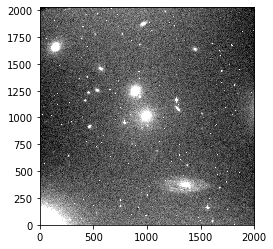

In [3]:
# how does it look?
plt.imshow(data, cmap='gray', origin='lower', vmin=23.0134, vmax=25.4417)

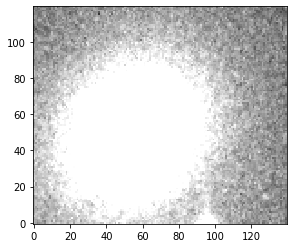

In [4]:
#cut
from astropy.nddata import Cutout2D
position = (902, 1257)
size=(120,140)
cutout=Cutout2D (data,position,size)
plt.imshow(cutout.data,cmap='gray', origin='lower', vmin=23.0134, vmax=25.4417)

We first need to estimate an initial guess of the ellipse geometry and pass it to the fitters.

In [13]:
# image statistics 
mean, median, std = sigma_clipped_stats(cutout.data, sigma=3.0)
# subract background
data_sub = cutout.data - median
# first guess
cat = data_properties(data_sub)
columns = ['id', 'xcentroid', 'ycentroid', 'semimajor_axis_sigma',
           'semiminor_axis_sigma', 'orientation']
tbl = cat.to_table(columns=columns)
# initialize an ellipse with the properties that we guessed
geometry = EllipseGeometry(x0=tbl['xcentroid'][0].value,
                           y0=tbl['ycentroid'][0].value,
                           pa=np.deg2rad(tbl['orientation'][0].value),
                           sma=tbl['semimajor_axis_sigma'][0].value,
                           eps=tbl['semiminor_axis_sigma'][0].value/tbl['semimajor_axis_sigma'][0].value
                           )

In [14]:
tbl

id,xcentroid,ycentroid,semimajor_axis_sigma,semiminor_axis_sigma,orientation
,pix,pix,pix,pix,deg
int64,float64,float64,float64,float64,float64
1,55.580559529627976,48.6544060612447,16.313222186867183,14.705773861704238,49.75939893093709


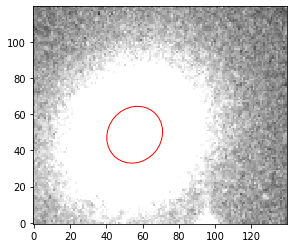

In [15]:
# how does it look?
plt.imshow(cutout.data, cmap='gray', origin='lower', vmin=23.0134, vmax=25.4417)
geometry.sma
aper = EllipticalAperture(positions=(geometry.x0, geometry.y0), 
                          a=geometry.sma,
                          b=geometry.sma*(geometry.eps),
                          theta=geometry.pa)
aper.plot(color='r')

Now we want to initiliaze an instance of the Ellipse class with the data and our initial guess and fit the data:

In [16]:
ellipse = Ellipse(data_sub, geometry)
isolist = ellipse.fit_image()

In [17]:
# save the output as a table
tab = isolist.to_table()
tab

sma,intens,intens_err,ellipticity,ellipticity_err,pa,pa_err,grad,grad_err,grad_rerr,x0,x0_err,y0,y0_err,ndata,flag,niter,stop_code
,,,,,deg,deg,,,,,,,,,,,
float64,float64,float64,float64,float64,float64,float64,float64,object,object,float64,float64,float64,float64,int64,int64,int64,int64
0.0,65.20262071828026,0.0,0.0,0.0,0.0,0.0,0.0,None,None,55.28894437652654,0.0,49.08986617118129,0.0,1,0,0,0
0.5277194311739052,64.48733577722143,0.05393565704385546,0.33245438433135477,0.028897082088766297,4.240549788168103,3.1876810991984903,-2.544703706976595,1.6669781690456635,0.655077510389698,55.28894437652654,0.011421642362468037,49.08986617118129,0.008136361996506126,13,0,10,0
0.5804913742912957,64.3471398681943,0.0578476664467642,0.31791169754339427,0.02835148290133624,5.662959223781735,3.2435136670468157,-2.5840806955436633,1.6336370488086085,0.6321927374891474,55.3158200634842,0.012061909267327878,49.10496939863036,0.008803656029620091,13,0,10,0
0.6385405117204254,64.1749871859204,0.062029260412845226,0.2869368553739712,0.022902397077313286,7.5053783495865645,2.850584526825309,-3.249630414953418,1.4973769075796934,0.4607837558047836,55.3491184866464,0.010235191538344532,49.12867619102678,0.007838928422079736,13,0,10,0
0.7023945628924679,63.78806131871135,0.062007982037048076,0.1500170543338425,0.019150125404290865,14.922022964519131,4.221844751621257,-4.2202083633490455,1.3961647803751602,0.33082839996724733,55.35634340477438,0.007878627162233158,49.157514398855156,0.0072190764779876595,13,0,10,0
0.7726340191817147,63.47486318207625,0.071461653580386,0.1023481741309117,0.019694745288455863,42.675949889672815,6.204219249265148,-4.519120552578881,1.4091736226370783,0.31182474692623974,55.36165401485406,0.008316384448443974,49.17830013705269,0.008285188487576822,13,0,10,0
0.8498974210998862,63.152493184126676,0.07471406001785863,0.1023481741309117,0.01556716516110781,65.60104369206935,4.903493439853018,-5.465187553719931,1.2128627131848413,0.22192517663173245,55.36524531115529,0.007105402545955264,49.19490742851556,0.007325155755747422,13,0,10,0
0.9348871632098749,62.76802520608396,0.06878013028585821,0.12688681541085073,0.012594278186256865,67.31135791798397,3.24072076897304,-5.497636138089407,1.090707151420705,0.19839566024821684,55.35789570806835,0.006346452025011626,49.191304095388624,0.006685141078440482,13,0,10,0


<ErrorbarContainer object of 3 artists>

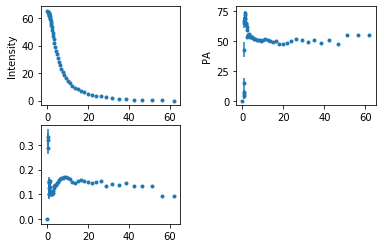

In [18]:
# have a look at some of the fitted parameters:
fig = plt.figure()
ax1 = fig.add_subplot(221)
fig.subplots_adjust(wspace=0.4)
ax1.errorbar(tab['sma'], tab['intens'],
             yerr=tab['intens_err'],
             fmt='.')
ax1.set_ylabel('Intensity')
ax2 = fig.add_subplot(222, sharex=ax1)
ax2.errorbar(tab['sma'], tab['pa'].value,
             yerr=tab['pa_err'].value,
             fmt='.')
ax2.set_ylabel('PA')
ax3 = fig.add_subplot(223, sharex=ax1)
ax3.errorbar(tab['sma'], tab['ellipticity'],
             yerr=tab['ellipticity_err'],
             fmt='.')
#ax3.set_ylabel('Ellipticity')
 #ax4 = fig.add_subplot(224, sharex=ax1)
 #ax4.errorbar(tab['sma'], tab['x0'],
                  #yerr=tab['x0_err'],
                  #fmt='.')
 #ax4.set_ylabel('x0')

We can also build a model image from the fit that we just calculated and deterime the residuals of the fit:

In [19]:
model_image = build_ellipse_model(cutout.data.shape, isolist)
residual = cutout.data - model_image

KeyboardInterrupt: 

In [ ]:
fig = plt.figure()
fig.subplots_adjust(wspace=0.5)
ax1 = fig.add_subplot(131)
ax1.imshow(cutout.data, cmap='gray', origin='lower')
ax1.set_title('Data')
ax2 = fig.add_subplot(132)
ax2.imshow(model_image, cmap='gray', origin='lower')
ax2.set_title('Model')
ax3 = fig.add_subplot(133)
ax3.imshow(residual, cmap='gray', origin='lower')
ax3.set_title('Residual')